In [274]:
import sys
sys.path.append('..')

from dotenv import load_dotenv
load_dotenv()

True

# Text Classification

## Dataset

In [275]:
import json

with open("../data/raw/sarcasm/samples.jsonl", "r") as f:
    data = [json.loads(item) for item in list(f)]

with open("../data/raw/sarcasm/few_shot.jsonl", "r") as f:
    few_shot = [json.loads(item) for item in list(f)]
    

In [276]:
data[0]

{'input': [{'role': 'system',
   'content': "Respond with only a 1 or 0 to signify if the user's message includes sarcasm, or not"},
  {'role': 'user',
   'content': 'thirtysomething scientists unveil doomsday clock of hair loss'}],
 'ideal': '1'}

In [277]:
data[1]

{'input': [{'role': 'system',
   'content': "Respond with only a 1 or 0 to signify if the user's message includes sarcasm, or not"},
  {'role': 'user',
   'content': 'dem rep. totally nails why congress is falling short on gender, racial equality'}],
 'ideal': '0'}

In [278]:
import random
seed = 42
n_samples = 1000
random.seed(seed)
sample_list = random.choices(data, k=n_samples)


In [279]:
f"Number of sarcasm samples: {len([c for c in sample_list if c['ideal'] == '1'])}"

'Number of sarcasm samples: 457'

In [280]:
f"Number of not sarcasm samples: {len([c for c in sample_list if c['ideal'] == '0'])}"

'Number of not sarcasm samples: 543'

## Non Guided Generation

In [281]:
openai_models = ['gpt-3.5-turbo', 'gpt-4-1106-preview', 'gpt-4']

In [282]:
from openai import OpenAI

client = OpenAI()

def generate_response(sample: dict, model: str):
    response = client.chat.completions.create(
        model=model,
        messages=sample['input'],
        temperature=0.0
    )
    response_message = response.choices[0].message.content
    response_cost =  openai_api_calculate_cost(response.usage, model=model)
    return {'response': response_message, 'cost': response_cost}

def openai_api_calculate_cost(usage, model):
    pricing = {
        'gpt-3.5-turbo': {
            'prompt': 0.001,
            'completion': 0.002,
        },
        'gpt-4-1106-preview': {
            'prompt': 0.01,
            'completion': 0.03,
        },
        'gpt-4': {
            'prompt': 0.03,
            'completion': 0.06,
        },
    }

    try:
        model_pricing = pricing[model]
    except KeyError:
        raise ValueError("Invalid model specified")

    prompt_cost = usage.prompt_tokens * model_pricing['prompt'] / 1000
    completion_cost = usage.completion_tokens * model_pricing['completion'] / 1000

    total_cost = prompt_cost + completion_cost


    return total_cost


In [283]:
generate_response(sample = data[0], model="gpt-3.5-turbo")

{'response': '0', 'cost': 4.8e-05}

In [284]:
generate_response(sample = data[0], model="gpt-4-1106-preview")

{'response': '1', 'cost': 0.00049}

In [285]:
for model in openai_models:
    for sample in sample_list:
        sample[model] = generate_response(sample, model)

In [286]:
for model in openai_models:
    print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
    print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for gpt-3.5-turbo: 0.546
Cost for gpt-3.5-turbo: 0.047959000000000106
Accuracy for gpt-4-1106-preview: 0.761
Cost for gpt-4-1106-preview: 0.4895900000000002
Accuracy for gpt-4: 0.74
Cost for gpt-4: 1.4387700000000005


## Instructor

In [287]:
import enum
from pydantic import BaseModel

class Labels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    SARCASM = "sarcasm"
    NOT_SARCASM = "not_sarcasm"

class SinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: Labels

In [288]:
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI())

def classify(sentence: str, model: str):
    """Perform single-label classification on the input text."""
    response = client.chat.completions.create(
        model=model,
        response_model=SinglePrediction,
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text: {sentence}",
            },
        ],
    )

    response_message = '1' if response.class_label == Labels.SARCASM else '0'
    response_cost =  openai_api_calculate_cost(response._raw_response.usage, model=model)
    return {'response': response_message, 'cost': response_cost}

In [289]:
classify(data[0]['input'][1]['content'], 'gpt-3.5-turbo')

{'response': '1', 'cost': 0.000115}

In [290]:
for model in openai_models:
    for sample in sample_list:
        sentence = sample['input'][1]['content']
        sample[f'instructor_{model}'] = classify(sentence, model)

In [291]:
for model in [f'instructor_{model}' for model in openai_models]:
    print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
    print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for instructor_gpt-3.5-turbo: 0.641
Cost for instructor_gpt-3.5-turbo: 0.11581599999999999
Accuracy for instructor_gpt-4-1106-preview: 0.741
Cost for instructor_gpt-4-1106-preview: 1.2299999999999995
Accuracy for instructor_gpt-4: 0.819
Cost for instructor_gpt-4: 3.4754400000000034


## Instructor (Replication)

In [292]:
import enum
from pydantic import BaseModel

class Labels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    SARCASM = "1"
    NOT_SARCASM = "0"

class SinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: Labels

In [293]:
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI())

def generate_classification(sample: dict, model: str):
    """Perform single-label classification on the input text."""
    response = client.chat.completions.create(
        model=model,
        response_model=SinglePrediction,
        temperature=0.0,
        messages=sample['input'],
    )

    response_message = '1' if response.class_label == Labels.SARCASM else '0'
    response_cost =  openai_api_calculate_cost(response._raw_response.usage, model=model)
    return {'response': response_message, 'cost': response_cost}

In [294]:
generate_classification(data[0], 'gpt-3.5-turbo')

{'response': '1', 'cost': 0.000123}

In [295]:
for model in openai_models:
    for sample in sample_list:
        sample[f'instructor_base_{model}'] = generate_classification(sample, model)

In [296]:
for model in [f'instructor_base_{model}' for model in openai_models]:
    print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
    print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for instructor_base_gpt-3.5-turbo: 0.661
Cost for instructor_base_gpt-3.5-turbo: 0.12295899999999953
Accuracy for instructor_base_gpt-4-1106-preview: 0.767
Cost for instructor_base_gpt-4-1106-preview: 1.2795899999999982
Accuracy for instructor_base_gpt-4: 0.79
Cost for instructor_base_gpt-4: 3.628050000000001


## Instructor (Mixing)

In [297]:
import enum
from pydantic import BaseModel

class NewLabels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    CLEARLY_SARCASM = "clearly_sarcasm"
    CLEARLY_NOT_SARCASM = "clearly_not_sarcasm"
    MAYBE_SARCASM = "maybe_sarcasm"
    MAYBE_NOT_SARCASM = "maybe_not_sarcasm"

class NewSinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: NewLabels

class Labels(str, enum.Enum):
    """Enumeration for single-label text classification."""
    SARCASM = "sarcasm"
    NOT_SARCASM = "not_sarcasm"

class SinglePrediction(BaseModel):
    """
    Class for a single class label prediction.
    """
    class_label: Labels

In [298]:
from openai import OpenAI
import instructor

client = instructor.patch(OpenAI())

def classify_mix(sentence: str):
    """Perform single-label classification on the input text."""
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        response_model=NewSinglePrediction,
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text: {sentence}",
            },
        ],
    )

    response_cost =  openai_api_calculate_cost(response._raw_response.usage, model="gpt-3.5-turbo")

    if response.class_label in [NewLabels.CLEARLY_SARCASM, NewLabels.CLEARLY_NOT_SARCASM]:
        response_message = '1' if response.class_label == NewLabels.CLEARLY_SARCASM else '0'
        return {'response': response_message, 'cost': response_cost}
    
    else:
        second_response = client.chat.completions.create(
        model="gpt-4-1106-preview",
        response_model=SinglePrediction,
        temperature=0.0,
        messages=[
            {
                "role": "user",
                "content": f"Classify the following text: {sentence}",
            },
        ],
        )

        response_message = '1' if second_response.class_label == Labels.SARCASM else '0'
        response_cost +=  openai_api_calculate_cost(second_response._raw_response.usage, model="gpt-4-1106-preview")

        return {'response': response_message, 'cost': response_cost} 

In [299]:
classify_mix(data[0]['input'][1]['content'])

{'response': '1', 'cost': 0.0013579999999999998}

In [300]:
for sample in sample_list:
    sentence = sample['input'][1]['content']
    sample[f'instructor_mixing'] = classify_mix(sentence)

In [301]:
model = 'instructor_mixing'
print(f"Accuracy for {model}: {sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list)}")
print(f"Cost for {model}: {sum([item[model]['cost'] for item in sample_list])}")

Accuracy for instructor_mixing: 0.714
Cost for instructor_mixing: 1.129674


## Results

In [314]:
import pandas as pd

model_labels = ['gpt-3.5-turbo', 'gpt-4-1106-preview', 'gpt-4',
                'instructor_gpt-3.5-turbo', 'instructor_gpt-4-1106-preview', 'instructor_gpt-4',
                'instructor_base_gpt-3.5-turbo', 'instructor_base_gpt-4-1106-preview', 'instructor_base_gpt-4',
                'instructor_mixing']

guide_labels = ['unguided', 'unguided', 'unguided',
                'guided', 'guided', 'guided',
                'guided', 'guided', 'guided',
                'guided']

llm_labels = ['gpt-3.5', 'gpt-4', 'gpt-4',
              'gpt-3.5', 'gpt-4', 'gpt-4',
              'gpt-3.5', 'gpt-4', 'gpt-4',
              'mix']

accuracy = []
cost = []
for model in model_labels:
    accuracy.append(sum([item[model]['response'] == item['ideal'] for item in sample_list]) / len(sample_list))
    cost.append(sum([item[model]['cost'] for item in sample_list]))

df = pd.DataFrame({'model': model_labels, 'accuracy': accuracy, 'cost': cost, 'guide': guide_labels, 'llm': llm_labels})


In [315]:
df

,model,accuracy,cost,guide,llm
0,gpt-3.5-turbo,0.546,0.047959,unguided,gpt-3.5
1,gpt-4-1106-preview,0.761,0.489590,unguided,gpt-4
2,gpt-4,0.740,1.438770,unguided,gpt-4
3,instructor_gpt-3.5-turbo,0.641,0.115816,guided,gpt-3.5
4,instructor_gpt-4-1106-preview,0.741,1.230000,guided,gpt-4
5,instructor_gpt-4,0.819,3.475440,guided,gpt-4
6,instructor_base_gpt-3.5-turbo,0.661,0.122959,guided,gpt-3.5
7,instructor_base_gpt-4-1106-preview,0.767,1.279590,guided,gpt-4
8,instructor_base_gpt-4,0.790,3.628050,guided,gpt-4
9,instructor_mixing,0.714,1.129674,guided,mix


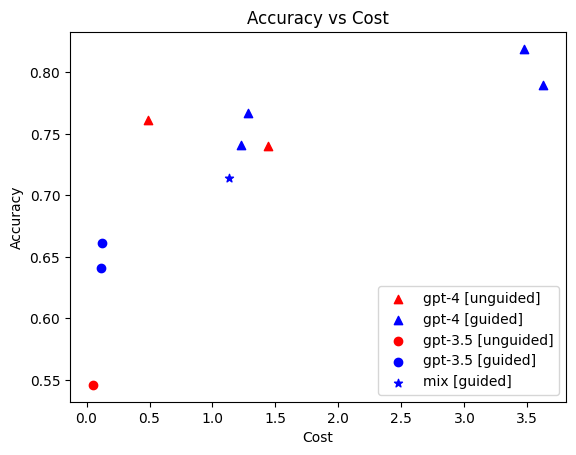

In [321]:
#plot accuracy vs cost
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.scatter(df[(df['llm'] == 'gpt-4')&(df['guide'] == 'unguided')]['cost'],
           df[(df['llm'] == 'gpt-4')&(df['guide'] == 'unguided')]['accuracy'], 
           marker='^', c='red', label='gpt-4 [unguided]')
ax.scatter(df[(df['llm'] == 'gpt-4')&(df['guide'] == 'guided')]['cost'],
           df[(df['llm'] == 'gpt-4')&(df['guide'] == 'guided')]['accuracy'], 
           marker='^', c='blue', label='gpt-4 [guided]')
ax.scatter(df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'unguided')]['cost'],
           df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'unguided')]['accuracy'], 
           marker='o', c='red', label='gpt-3.5 [unguided]')
ax.scatter(df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'guided')]['cost'],
           df[(df['llm'] == 'gpt-3.5')&(df['guide'] == 'guided')]['accuracy'], 
           marker='o', c='blue', label='gpt-3.5 [guided]')
ax.scatter(df[df['llm'] == 'mix']['cost'],
           df[df['llm'] == 'mix']['accuracy'], 
           marker='*', c='blue', label='mix [guided]')

plt.legend()

plt.xlabel('Cost')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Cost')
plt.show()

In [322]:
fig.savefig('../reports/figures/sarcasm_accuracy_vs_cost.png', dpi=300, bbox_inches='tight')

In [304]:
# sample_list to file
with open(f"../data/processed/sarcasm/openai_responses_s_{seed}_n_{n_samples}.jsonl", "w") as f:
    for item in sample_list:
        f.write(json.dumps(item) + "\n")

In [305]:
f'Total Cost: {sum(cost)}'

'Total Cost: 12.957848000000004'